<a href="https://colab.research.google.com/github/maciejskorski/ml_examples/blob/master/RenyiEntropyEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Renyi Entropy Estimation

This notebook demonstrates Renyi entropy estimation.

## Estimator

Renyi entropy is closely linked to collision probability by 
$$\mathbf{H}_d(X)=\frac{1}{1-d}\log P_d$$
where
$$
P_d \triangleq \mathbf{P}\{ X_1=\ldots=X_d\}= \sum_x p_X(x)^d,
$$
The collision probability, and hence Renyi entropy, can be approximated from samples by the birthday estimator:
$$
\widehat{P_d} (X_1,\ldots,X_n )  = {n \choose d}
  \sum_{i_1<i_2<\ldots<i_d} \mathbb{I}( X_{i_1}=X_{i_2}=\ldots=X_{i_d} ).
$$
As shown in the paper, the estimator is unbiased and its variance is bounded by
$$
\mathbf{Var}[\widehat{P_d}] \leqslant \frac{2d^2 P_d^{2-1/d}}{n},
$$
and the variance of the relative error is
$$
\mathbf{Var}[\widehat{P_d}/P_d-1] \leqslant \frac{2d^2}{P_d^{1/d}n}.
$$
The variance can be further decreased by the techniques of robust mean estimation.

## Collision Estimation Example

We study the Zipf distribution with parameter $s=2$ and the support size $K=10000$.

In [1]:
from scipy.special import binom
from collections import Counter
from scipy.stats import zipfian
import numpy as np
np.random.seed(42)

K = 10000
p = zipfian(a=2,n=K)
xs = np.arange(1,K+1)
p2 = p.pmf(np.arange(1,K+1))**2
p_col = p2.sum()
p_col.round(5)

0.40005

In [2]:
def estimate_collision(x,d=2):
  ''' "Birthday" estimator for collision probability 
        Input:
        samples: list of samples
        d: order of collision probablity to be estimated
        delta: desired confidence parameter
        prior_col_bound: a lower bound on the collision probability, required for error estimation
      Output: 
        estimate of d-th order collision probability
  '''
  cnt = Counter(x).values()
  cnt = np.array(list(cnt))
  col_est = binom(cnt,d).sum()/binom(cnt.sum(),d)
  return binom(cnt,d).sum()/binom(cnt.sum(),d)

def estimate_collision_high_conf(x,d=2,delta=0.05,prior_col_bound=None):
  ''' High-confidence estimator for collision probbility. 
      This implementation combines the birthday estimator and the median-of-means trick.
      Input:
        x: list of samples
        d: order of collision probablity to be estimated
        delta: desired confidence parameter
        prior_col_bound: a lower bound on the collision probability, required for error estimation
      Output: 
        a pair of estimate and relative error (error is None unless prior_col_bound is provided)
  '''
  n = len(x)
  k = int(np.ceil(8*np.log(1/delta)))
  x = np.resize(x,(k,int(np.floor(n/k))))
  p_cols = np.apply_along_axis(estimate_collision,0,x)
  if prior_col_bound is not None:
    err = 8*d/prior_col_bound**0.5 * (np.log(1/delta)/n)**0.5
  else:
    err = None
  return np.median(p_cols),err


def estimate_collision_adaptive_high_conf(x,d=2,delta=0.05,K=10000):
  ''' High-confidence adaptive estimator for collision probbility. 
      Input:
        x: list of samples
        d: order of collision probablity to be estimated
        delta: desired confidence parameter
        K: alphabet size
      Output: 
        a pair of estimate and relative error
  '''
  N = lambda delta,Q: round( 8*2**2*8*np.log(1/delta)*Q**(-1/2) )
  Q = 1
  Q_is_bound = True
  while Q_is_bound and Q > K**(1-d):
    Q = Q/2
    n_subsample = N(delta/np.log2(K),Q)
    subsample = x[:n_subsample]
    col_estimate = estimate_collision(subsample)
    Q_is_bound = col_estimate < Q
    print(n_subsample,col_estimate,Q)
  p_est,err = estimate_collision_high_conf(x,d,delta/2,Q/2)
  return (p_est,err)

In [3]:
n = 20000
samples = p.rvs(size=n)

print(estimate_collision(samples))
print(estimate_collision_high_conf(samples))
print(estimate_collision_adaptive_high_conf(samples,K=10000))

0.4024072703635182
(0.391304347826087, None)
2021 0.3931628788806639 0.5
2858 0.3951869042017531 0.25
(0.3988505747126437, 0.6146065864447493)


## Uniformity Testing

### Background



1. The quantitiy of interest is $$y = P_2-\frac{1}{m} = \sum_x \left(p(x)-\frac{1}{m}\right)^2,$$ the difference between the actual collision probability and that of a uniform distribution. 
2. Proving that $y>0$ with statistical significance proves non-uniformity. To this end, consider the estimator
$$\widehat{y} = \widehat{P_2}-\frac{1}{m}$$ 
using the birthday collision estimator $\widehat{P_2}$ from $n$ samples.
3. The estimator $\widehat{y}$ has the standard deviation bounded by (see the paper for a proof)
$$
\sqrt{\mathbf{Var}[\widehat{y}]} \leqslant \sqrt{\frac{4 y^{\frac{3}{2}} + \frac{4 y}{m}}{n} + \frac{2 y + \frac{2}{m}}{n \left(n - 1\right)}},
$$
which can be used to derive confidence/credibility intervals for unknown $y$ from observed $\widehat{y}$.

In [4]:
import sympy as sm
from sympy import solve_univariate_inequality

def sigma(y,n,m):
  return sm.sqrt(4*(y/m+sm.sqrt(y)**(3))/n+2*(y+1/m)/(n*(n-1)))

y,n,m,delta = sm.symbols('y,n,m,delta',positive=True)
sigma(y,n,m)

sqrt((4*y**(3/2) + 4*y/m)/n + (2*y + 2/m)/(n*(n - 1)))

### Inference Exampkle

We confirm non-uniform distribution of births over weekday and month, using: 


1.   U.S. births data from 2000 to 2014, as provided by the Social Security Administration. The [dataset is available at GitHub](https://github.com/fivethirtyeight/data/tree/master/births).
2.   Births from insurance claims, provided by Roy Murphy. The [dataset is available on his webpage](https://https://www.panix.com/~murphy/bdata.txt).





In [5]:
import pandas as pd

!curl -o birthdays.csv https://www.panix.com/~murphy/bdata.txt # downloiad data
df = pd.read_csv('birthdays.csv',sep=' ') # read as dataframe
df = df[:-1] # skip control row
df['date'] = pd.to_datetime('2000'+df['date']) # convert dates
df.rename({'count':'births'},axis='columns',inplace=1)
df.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4049  100  4049    0     0   7654      0 --:--:-- --:--:-- --:--:--  7654


,date,births
0,2000-01-01,1482
1,2000-01-02,1213
2,2000-01-03,1220
3,2000-01-04,1319
4,2000-01-05,1262


In [6]:
birthdays1 = df.groupby(df['date'].dt.month_name())['births'].sum()
birthdays1

date
April        37641
August       42980
December     40320
February     36753
January      40255
July         42148
June         38789
March        39940
May          39288
November     38940
October      41874
September    42112
Name: births, dtype: int64

In [7]:
import pandas as pd
host = 'raw.github.com'
user = 'fivethirtyeight'
repo = 'data'
branch = 'master'
file = 'births/US_births_2000-2014_SSA.csv'
url = f'https://{host}/{user}/{repo}/{branch}/{file}'
df = pd.read_csv(url,sep=',',header=0)
df['date'] = df[['year','month','date_of_month']].astype(str).apply('-'.join,axis=1)
df['date'] = pd.to_datetime(df['date'])
df = df[['date','births']]
df.head()

,date,births
0,2000-01-01,9083
1,2000-01-02,8006
2,2000-01-03,11363
3,2000-01-04,13032
4,2000-01-05,12558


In [8]:
birthdays2 = df.groupby([df['date'].dt.day_of_week,df['date'].dt.day_name()])['births'].sum()
birthdays2 = birthdays2.droplevel(0,'index')

Birthday on same day probability 0.08351
Collision probability of a distribution uniform over 7 elements is 	0.08333


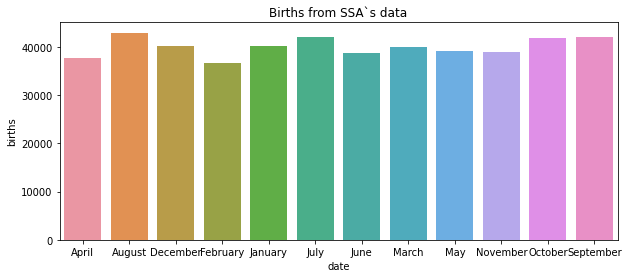

(9.02907199572759e-5 <= y) & (y <= 0.000345551030531635)
Birthday on same day probability 0.14794
Collision probability of a distribution uniform over 7 elements is 	0.14286


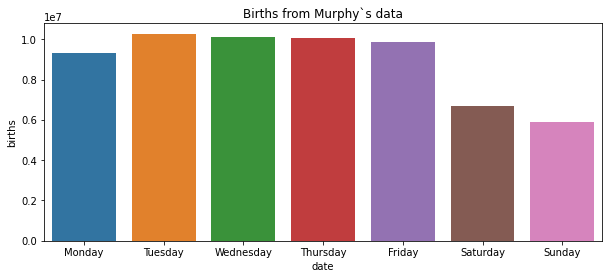

(0.00499508345980237 <= y) & (y <= 0.00516234863382153)


In [9]:
import numpy as np
from scipy.special import binom
import seaborn as sns
import matplotlib.pyplot as plt


titles = ['Births from SSA`s data','Births from Murphy`s data']

for birthdays,label in zip([birthdays1,birthdays2],titles):

  p_col = binom(birthdays,2).sum()/binom(birthdays.sum(),2)
  n = birthdays.sum()
  m = len(birthdays)
  gap_col = p_col-1/m

  print('Birthday on same day probability {:.5f}'.format(p_col))
  print('Collision probability of a distribution uniform over 7 elements is 	{:.5f}'.format(1/m))

  fig,ax = plt.subplots(figsize=(10,4))
  sns.barplot(data=birthdays.reset_index(),x='date',y='births',ax=ax)
  ax.set_title(label)
  plt.show()

  y,n,m,delta = sm.symbols('y,n,m,delta',positive=True)
  subs = {n : birthdays.sum(), m : len(birthdays)}
  sigma_subs = sigma(y,n,m).subs(subs)
  print(solve_univariate_inequality(abs(y-gap_col) <= 10*sigma_subs, y))